Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
%matplotlib inline

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    #raise Exception(
    #  'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
print(type(words))
print(type(words[0]))
print(len(words))

for i in range(8):
    print(words[i])

<class 'list'>
<class 'str'>
17005207
anarchism
originated
as
a
term
of
abuse
first


In [6]:
count = collections.Counter(words)

In [7]:
print(type(count))

<class 'collections.Counter'>


In [52]:
print(len(count))

253854


In [23]:
print(len(count.keys()))

253854


In [46]:
print(count['as'])

131815


In [65]:
count_common = collections.Counter(words).most_common(50000 - 1)

In [66]:
print(type(count_common))

<class 'list'>


In [67]:
print(type(count_common[0]))

<class 'tuple'>


In [68]:
print(len(count_common))

49999


In [76]:
print(count_common[0][0])

the


In [81]:
myDict = {}
for word,_ in count_common:
    myDict[word] = len(myDict)
    
#myDict demonstrate the order of numbers word descreasing

In [82]:
print (myDict['the'])

0


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = {}
  
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = []
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.
print(len(data))

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
17005207


In [5]:
print(count[dictionary['the']])
print(count[5234])
#print(words[0])
print(reverse_dictionary[data[0]])
#print(reverse_dictionary[0])
#print(words[1])
print(reverse_dictionary[data[1]])

print(reverse_dictionary[0])

('the', 1061396)
('anarchism', 303)
anarchism
originated
UNK


+ data: data[i] mean: words[i] rank data[i]th in the ranking of number word appear
+ dictionary: dictionary['the'] is the ranking of the word 'the'
+ ==> reverse_dictionary[data[i]] is the same as words[i]
+ reverse_dictionary is the oder list of word (decrease the number of appear)
+ count: count common 50000 word that count['the'] is the number appear 'the', count is sort decrease, however, count[0] is the tupple of unknown word

Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for num_skips, skip_window in [(2, 3), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_skips = 2 and skip_window = 3:
    batch: ['a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used', 'against', 'against', 'early', 'early']
    labels: ['abuse', 'anarchism', 'a', 'first', 'as', 'first', 'of', 'used', 'early', 'term', 'early', 'abuse', 'early', 'class', 'used', 'against']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['originated', 'anarchism', 'term', 'a', 'term', 'originated', 'of', 'as', 'a', 'of', 'abuse', 'as', 'term', 'abuse', 'a', 'first']


+ what we have in the batch, batch contains 8 words, so batch[0] is the rank of the word for embedding 

Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.

    #test the shape
  print(embed.shape)
  print(softmax_weights.shape)
  print((tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)).shape)


    #end test the shape
    
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    
    
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  print(norm.shape)
  normalized_embeddings = embeddings / norm
  print(normalized_embeddings.shape)
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)

  print(valid_embeddings.shape)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Colocations handled automatically by placer.
(128, 128)
(50000, 128)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
(128,)
Instructions for updating:
Use tf.cast instead.
(50000, 1)
(50000, 128)
(16, 128)


+ tf.nn.embedding_lookup(embeddings, train_dataset) explain: https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do. 
+ How can I embedding a word:
+ + I have an embedding weight (that is what we want to know after training, at first, we init it)
+ + An embedding weight has a shape = [vocab_size, embedding size]
+ + what is embedding size, for example, embedding_size = 3, like R,G,B value --> color
+ + Embedding the word by finding how popular of it in the vocab, if it is the most appear one, that value is 1
+ + So embedding_weight[1] is the embedding of that word


In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.053966
Nearest to will: surinam, excessive, perlite, affectionately, rebellion, tacitus, banner, enthusiast,
Nearest to had: intelsat, expropriated, inca, harness, courtyard, deaf, limb, hegel,
Nearest to three: bce, unknowable, capitalists, anteaters, flourished, chaos, bomarc, mannered,
Nearest to no: cleanse, choreographed, billy, publius, suicides, devils, hugo, contrapuntal,
Nearest to was: karenga, insists, mandating, independently, refractory, wool, playwrights, wondered,
Nearest to american: predation, curtius, glucocorticoids, sweeps, convention, stub, ramon, nuclear,
Nearest to called: beginners, alfons, lucrative, remember, coat, symbols, hillsides, fours,
Nearest to of: sulfide, meals, rogues, pivot, carlos, romanized, consciously, flipping,
Nearest to only: behaviour, evading, tasteless, knudsen, postcard, zum, jagiello, competitor,
Nearest to has: ludvig, secluded, lodge, benefitting, bitches, antiparticles, courage, transcripts,
Near

Average loss at step 52000: 3.438134
Average loss at step 54000: 3.428601
Average loss at step 56000: 3.437615
Average loss at step 58000: 3.397226
Average loss at step 60000: 3.396167
Nearest to will: would, could, can, may, must, should, might, cannot,
Nearest to had: has, have, was, were, executing, having, been, ver,
Nearest to three: five, four, six, two, seven, eight, nine, zero,
Nearest to no: any, publius, little, ln, rarely, formulations, absorb, picasso,
Nearest to was: is, became, had, were, has, did, be, been,
Nearest to american: british, canadian, australian, tsar, komodo, russian, italian, indian,
Nearest to called: named, used, referred, alfons, altruistic, considered, amraam, pardons,
Nearest to of: in, for, including, exact, same, dissonant, hellenistic, deirdre,
Nearest to only: always, encoded, never, usually, first, until, wavetable, mackay,
Nearest to has: had, have, was, is, having, thine, demonstrably, ore,
Nearest to the: its, their, a, this, any, his, ostpolit

All understand above

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

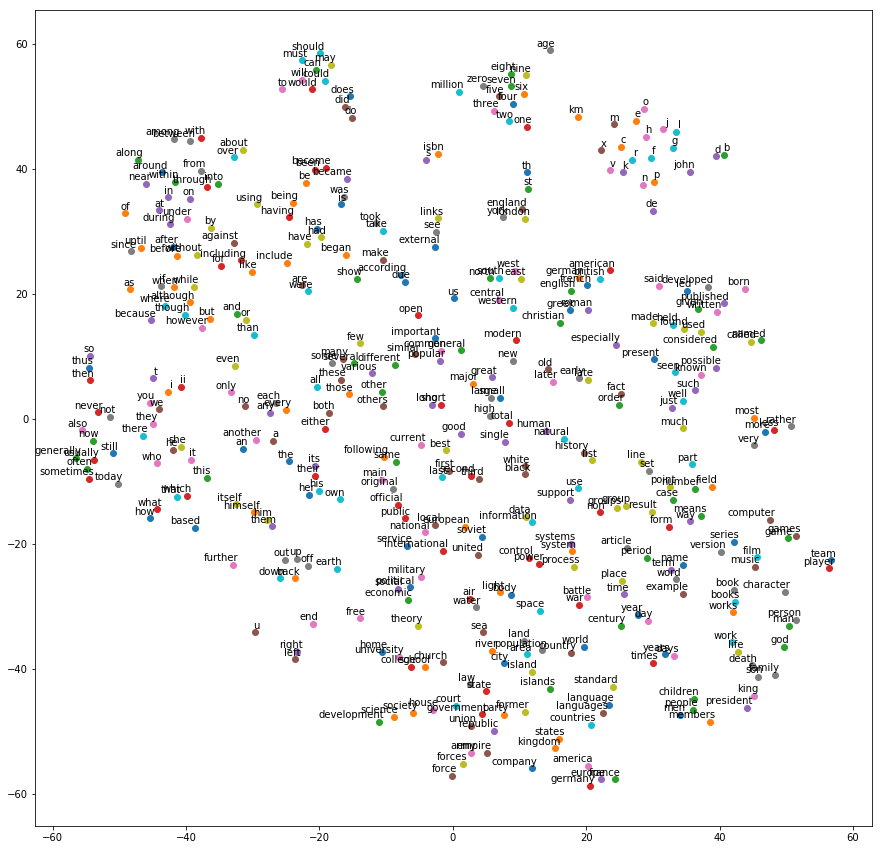

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

#### Generate input and label for CBOW model

In [29]:
data_index = 0

def generate_cbow_batch(batch_size, num_cbows, cbow_window):
  global data_index
  assert batch_size % num_cbows == 0
  assert num_cbows <= 2*cbow_window

  batch = np.ndarray(shape=(batch_size // num_cbows, num_cbows), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size // num_cbows, 1), dtype=np.int32)

  span = 2*cbow_window+1
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index+1) % len(data)


  for i in range(batch_size // num_cbows):
    target = cbow_window
    target_to_avoid = [cbow_window]

    labels[i,0] = buffer[cbow_window]

    for j in range(num_cbows):
      while target in target_to_avoid:
        target = random.randint(0, span - 1)

      target_to_avoid.append(target)

      batch[i, j] = buffer[target]


    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)


  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_cbows, cbow_window in [(2,1), (4,2)]:
    data_index = 0
    batch, labels = generate_cbow_batch(batch_size=8,num_cbows=num_cbows, cbow_window=cbow_window)
    print('\nwith num_cbow = %d and cbow_window = %d: ' %(num_cbows, cbow_window))
    print('    batch:', [[reverse_dictionary[bij] for bij in bi] for bi in batch])
    #print('    labels:', [[reverse_dictionary[lij] for lij in li] for li in labels])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8//num_cbows)])



data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_cbow = 2 and cbow_window = 1: 
    batch: [['as', 'anarchism'], ['a', 'originated'], ['as', 'term'], ['of', 'a']]
    labels: ['originated', 'as', 'a', 'term']

with num_cbow = 4 and cbow_window = 2: 
    batch: [['term', 'originated', 'a', 'anarchism'], ['as', 'originated', 'term', 'of']]
    labels: ['as', 'a']


#### Training cbow model

In [30]:
batch_size = 128
embedding_size = 128
num_cbows = 4
cbow_window = 2

num_sampled = 64  # Number of negative examples to sample.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

graph = tf.Graph()

with graph.as_default():
  # Input
  train_dataset = tf.placeholder(shape=(batch_size // num_cbows, num_cbows), dtype=tf.int32)
  train_labels = tf.placeholder(shape=(batch_size // num_cbows, 1), dtype=tf.int32)
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # weight
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
  )

  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size], stddev=1 / math.sqrt(embedding_size))
  )

  softmax_biases = tf.Variable(tf.zeros(shape=[vocabulary_size]))

  # Model

  # Lookup
  embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset), axis=1)

  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
  )


  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  print(norm.shape)
  normalized_embeddings = embeddings / norm
  print(normalized_embeddings.shape)
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)

  print(valid_embeddings.shape)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(50000, 1)
(50000, 128)
(16, 128)


#### Run session

In [31]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, num_cbows, cbow_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.393681
Nearest to no: stacking, away, norwegians, mai, unsuccessfully, break, deflate, uprisings,
Nearest to have: conjugal, watchers, hz, connacht, catamaran, puns, spherically, edvard,
Nearest to time: drainage, carbohydrates, landlord, drosophila, misunderstandings, monotonic, hydrazine, mears,
Nearest to was: kayak, unmik, palm, raptor, zimri, ambulances, reclassified, sempronius,
Nearest to known: esophagus, executing, norm, subkey, namely, parrish, lysergic, dedham,
Nearest to between: strawberries, hallucinations, fittingly, move, tirthankaras, wouldn, rsdlp, avro,
Nearest to history: langmuir, traffickers, lombardi, howto, berman, arnstadt, parcham, bluetooth,
Nearest to american: fait, lct, shoot, respondent, bladder, blanton, balls, feline,
Nearest to war: jref, alarc, masterful, cura, emotionally, wishing, circumference, ee,
Nearest to all: cinematographers, philharmonic, cpm, unsuited, intercalary, arriving, blok, presumption,
Nearest t

Average loss at step 52000: 3.587551
Average loss at step 54000: 3.738240
Average loss at step 56000: 3.675042
Average loss at step 58000: 3.531260
Average loss at step 60000: 3.605810
Nearest to no: any, this, another, a, clam, mooney, bestowed, acadian,
Nearest to have: has, offer, had, represent, were, possess, carry, be,
Nearest to time: decreed, narrow, jurisdiction, uruguayan, shooting, end, least, naur,
Nearest to was: is, had, were, are, has, became, conde, remained,
Nearest to known: referred, used, recognized, described, follows, seen, opposed, prescient,
Nearest to between: within, industrialized, throughout, since, efnet, breastplate, in, gallows,
Nearest to history: physik, jh, swordsmen, temp, alfredo, blackbody, semite, description,
Nearest to american: coastlines, egalitarian, korean, australian, precious, jenna, variadic, plotting,
Nearest to war: nazi, complaint, pendleton, spear, ravages, shadow, classmates, arrest,
Nearest to all: mitzvah, citeaux, other, corsica, r

In [32]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

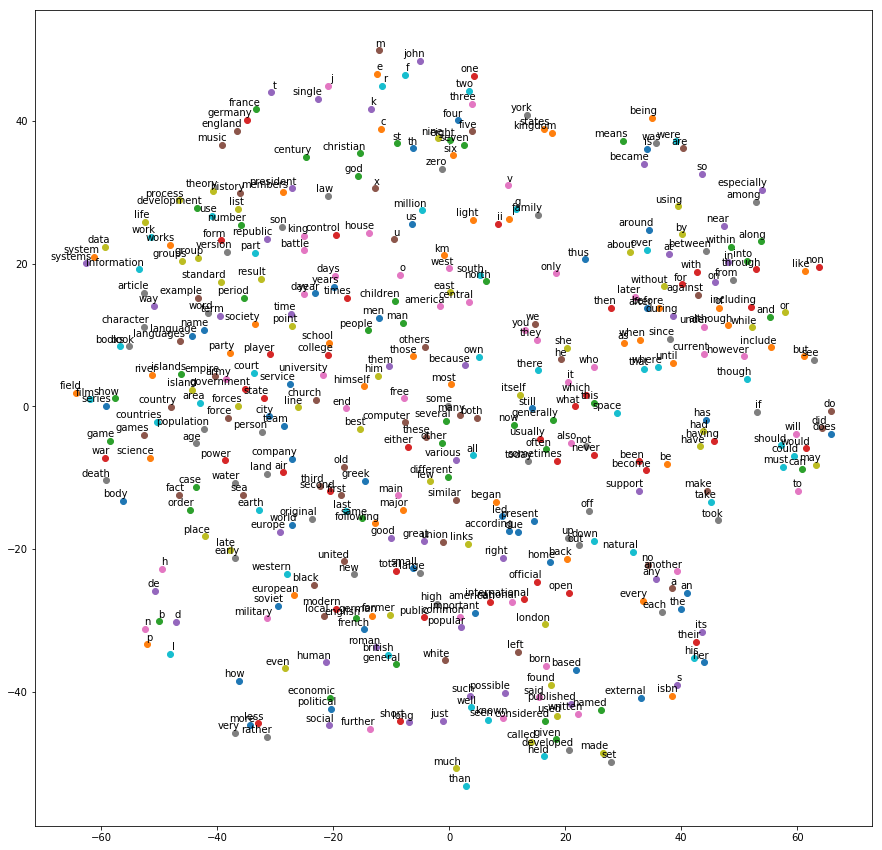

In [33]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)